In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii
from pathlib import Path
import yt
import sys
sys.path.insert(0,'/home/cjlee/practice/athena/vis/python')
import athena_read
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from mpl_toolkits.axes_grid1 import AxesGrid
import pickle
import os
from mpl_toolkits.axes_grid1 import ImageGrid,Grid
from matplotlib import gridspec
from scipy.optimize import curve_fit
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [2]:
path2='/data/cjlee/hii/various_nH0_Qi/vesc_test3'
datapath=Path(path2)
pathlist=list(datapath.glob('hii*'))

ind=np.array([2,3,0,4,1,5])
pathlist2=[]
for i in range(len(pathlist)):
    pathlist2.append(pathlist[ind[i]])
pathlist2

[PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_0.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_0.5'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_1.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_1.5'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_2.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_2.5')]

In [3]:
def integrate(dt,dvdt):
    dv=dt*dvdt
    return np.array([np.sum(dv[:l]) for l in range(len(dt))])

In [4]:
path1=str(pathlist2[0])
s1=pa.LoadSim(path1)
datapath_=Path(str(path1)+'/evap_dictionary')
pathlist_dict=list(datapath_.glob('*t*'))
dict_list=[]
for i in range(0,len(pathlist_dict),1):
    print(i)
    ph=str(pathlist_dict[i])
    with open(ph, 'rb') as fr:
        rr = pickle.load(fr)
    dict_list.append(rr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [10]:
path2=str(pathlist2[2])
s2=pa.LoadSim(path2)
datapath_=Path(str(path2)+'/evap_dictionary')
pathlist_dict=list(datapath_.glob('*t*'))
dict_list2=[]
for i in range(0,len(pathlist_dict),1):
    print(i)
    ph=str(pathlist_dict[i])
    with open(ph, 'rb') as fr:
        rr = pickle.load(fr)
    dict_list2.append(rr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [5]:
def func(x,a):
    return 1/(1+a**2*(1/x-1)**2)**1

In [6]:
t=np.array([rr['time'] for rr in dict_list])
a_para=np.array([rr['a_para'] for rr in dict_list])
a_para2=np.array([rr['a_para2'] for rr in dict_list])
a_err=np.sqrt(np.array([rr['a_err'] for rr in dict_list]))
a_err2=np.sqrt(np.array([rr['a_err2'] for rr in dict_list]))

<>:3: SyntaxWarning: invalid escape sequence '\%'
<>:3: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_142452/440432770.py:3: SyntaxWarning: invalid escape sequence '\%'
  axes[0].plot(t,a_para2,'b',label='for $r_{evap,95\%}$')


Text(0, 0.5, 'standare err')

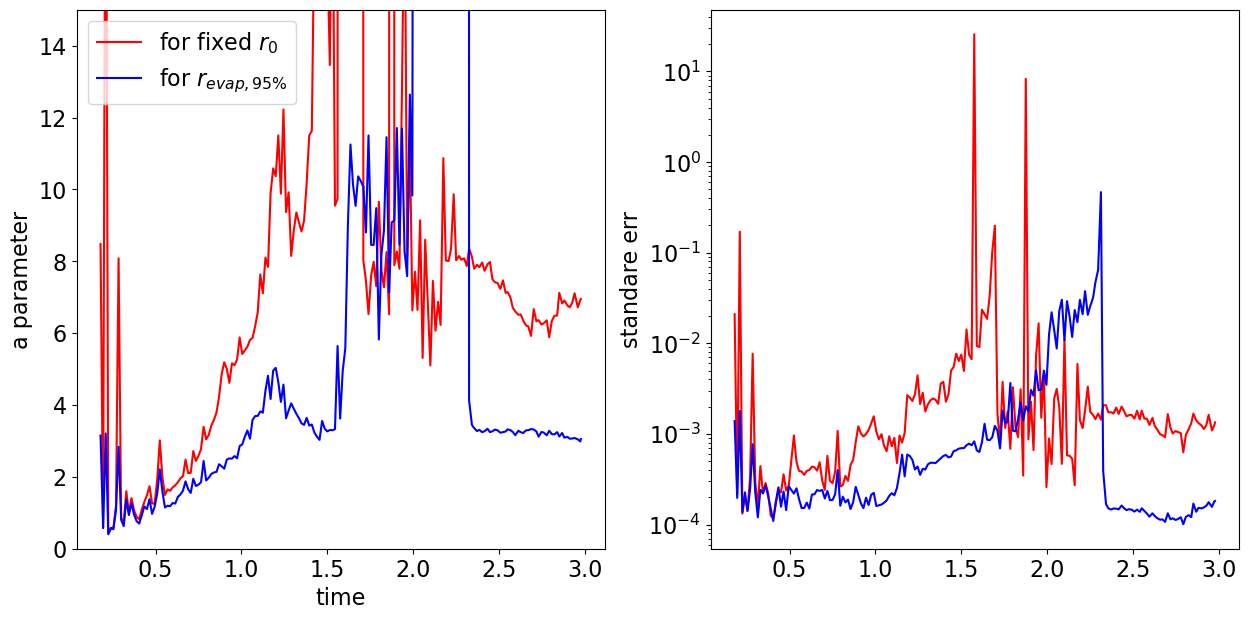

In [9]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(t,a_para,'r',label='for fixed $r_0$')
axes[0].plot(t,a_para2,'b',label='for $r_{evap,95\%}$')
axes[1].plot(t,a_err,'r')
axes[1].plot(t,a_err2,'b')
axes[0].set_ylim(0,15)
axes[0].legend(loc='upper left')
axes[1].set_yscale('log')
axes[0].set_xlabel('time')
axes[0].set_ylabel('a parameter')
axes[1].set_ylabel('standare err')

19.737535649253623 0.00020184666541150724
401.64900448331133 664.7508343795214
22.691047937985214 0.0005533114606344837
34.08004889911561 0.00043949175366699933
48.09758632906238 0.00034629618748364515
58.4771065549723 0.0011370579148743613
124.96426927442351 0.010422525389053161
261.09867169142774 0.039481693453603875
422.8373409400306 68.77793490986883
18.97044706217252 0.0002762987925487493
5.100170421684022 0.0001241224647653626


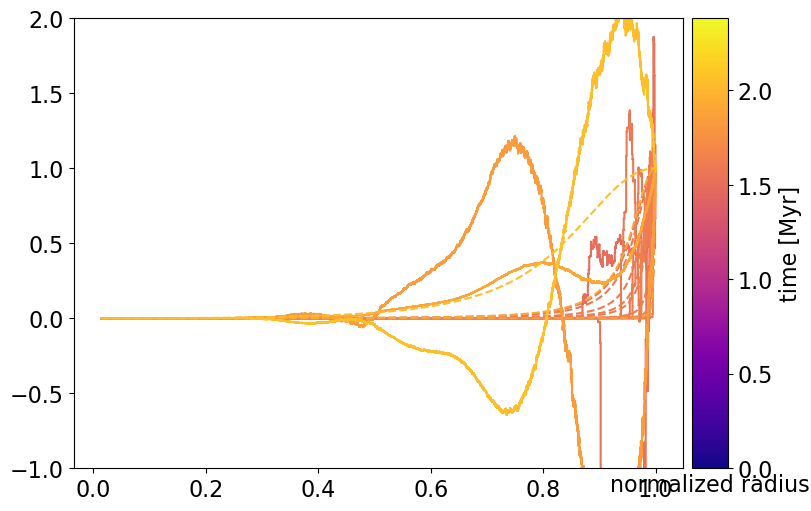

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[0.5,0.03]))
norm = plt.Normalize(0, 0.8*s1.par['time']['tlim'])
cmap = mpl.cm.plasma
for i in s1.nums[20:]:
    
    rr=dict_list[i]
    popt,pcov=rr['a_para'],rr['a_err']
    if np.sqrt(pcov)>0.01:
        r0=rr['r0']
        ind=rr['r']<=r0
        radius=rr['r'][ind]
        
        M_ev=rr['dot_M_ev'][ind]
        x=radius/radius[-1]
        y=M_ev/M_ev[-1]
    
        if M_ev[-1]==0:
            y=np.zeros(len(y))
        axes[0].plot(x,y,'-',c=cmap(norm(rr['time']*s1.u.Myr)))
        axes[0].plot(x,func(x,popt),'--',c=cmap(norm(rr['time']*s1.u.Myr)))
        print(popt,pcov)
plt.xlabel('normalized radius')
plt.ylabel('normalized m_evap')
axes[0].set_ylim(-1,2)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, cax=axes[-1], label='time [Myr]')

In [6]:
bins={}
bins['radius']=np.linspace(0,s1.par['mesh']['x1max']*np.sqrt(3),200)
bins['nH']=np.logspace(-3,3,200)
bins['vr']=np.linspace(-50,50,200)
Ti=8000
ci=11.1*np.sqrt(Ti/10**4)

In [7]:
def nH_xn(s,num):
    ds=s.load_hdf5(num,load_method='yt')
    add_fields(ds,s)
    rr=dict_list[num]
    r0=rr['r0']
    sp=ds.sphere([0,0,0],1.01*r0)

    r0=rr['r0']
    sp=ds.sphere([0,0,0],1.01*r0)
    nH=sp.extract_isocontours('radius',r0,None,False,'nH')[1]
    xn=sp.extract_isocontours('radius',r0,None,False,'r0')[1]
    H, xe, ye = np.histogram2d(xn, nH, bins=[np.linspace(0,1,50),np.logspace(-3.5,3.5,100)], weights=None)
    h=np.histogram(rr['f_esc_Om'],bins=np.linspace(0,1,50))
    x,y=h[0],h[1]

    fig = plt.figure(figsize=(8, 6)) 
    axes = gridspec.GridSpec(nrows=2, # row 몇 개 
                       ncols=2, # col 몇 개 
                       height_ratios=[1, 2], 
                       width_ratios=[2, 1]
                      )
    ax=plt.subplot(axes[0])
    ax.plot(0.5*(xe[:-1]+xe[1:]),np.sum(H,axis=1)/np.sum(H),'k')
    ax.set_yscale('log')
    ax.set_xlim(0,1)
    ax.set_ylim(1e-4,1)
    ax.set_yticks((1e-2,1),(1e-2,1))
    ax.get_xaxis().set_ticks([])
    ax.plot(1-0.5*(y[1:]+y[:-1]),x/np.sum(x),'k--',label='$1-f_{esc}$')
    ax.legend()
    
    ax=plt.subplot(axes[3])
    ax.plot(np.sum(H,axis=0)/np.sum(H),(ye[:-1]*ye[1:])**0.5,'k')
    
    ax.plot(np.sum(H[:25,:],axis=0)/np.sum(H),(ye[:-1]*ye[1:])**0.5,'k--',label='ion')
    ax.plot(np.sum(H[25:,:],axis=0)/np.sum(H),(ye[:-1]*ye[1:])**0.5,'k-.',label='neu')
    ax.legend(loc='lower right')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-3,1e+3)
    ax.set_xticks((1e-3,1e-1),(1e-3,1e-1))
    ax.get_yaxis().set_ticks([])

    ax=plt.subplot(axes[2])
    ax.set_yscale('log')
    ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), cmap=mpl.cm.plasma, alpha=0.5)
    ax.set_ylim(1e-3,1e+3)
    ax.set_xlim(1e-4,1)
    ax.set_xlabel('neutral fraction')
    ax.set_ylabel('number density')
    ax.text(0.05,300,'t={:.3f}'.format(ds.current_time.to('Myr')),fontsize=14)
    ax.set_xticks((0,0.2,0.4,0.6,0.8),(0,0.2,0.4,0.6,0.8))
    
    plt.subplots_adjust(wspace=0,hspace=0)
    return


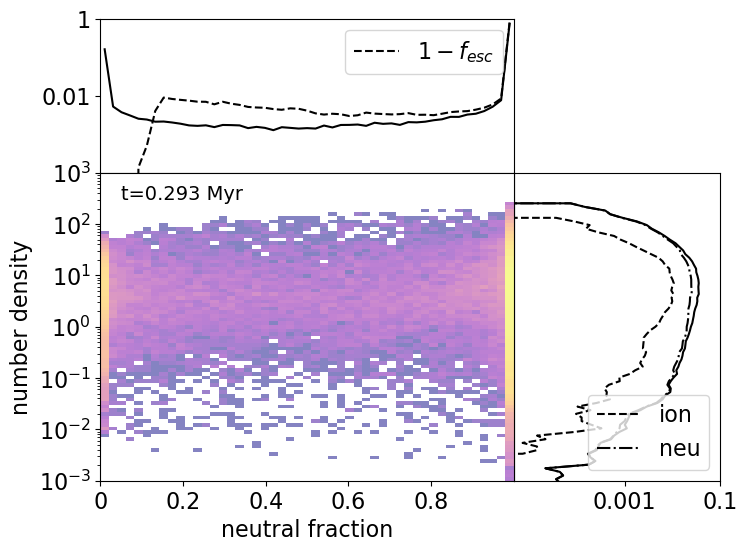

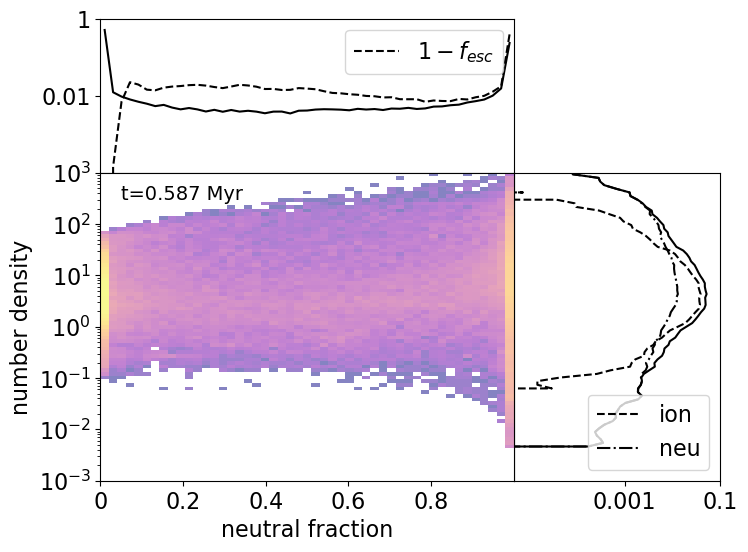

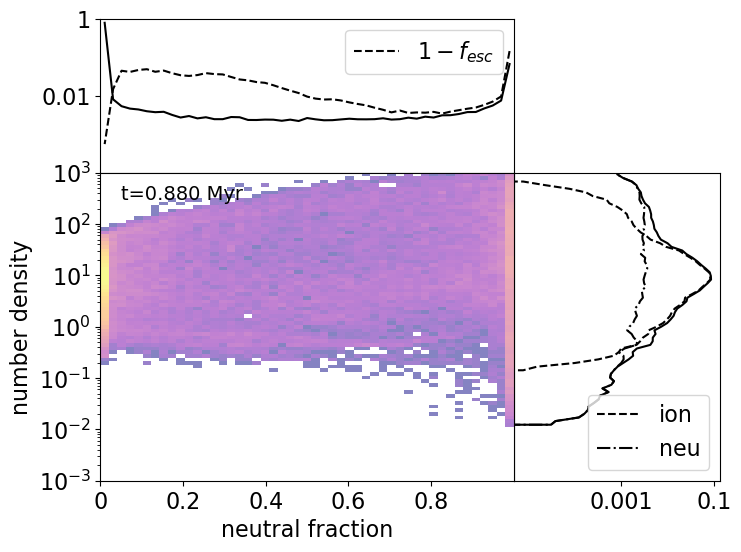

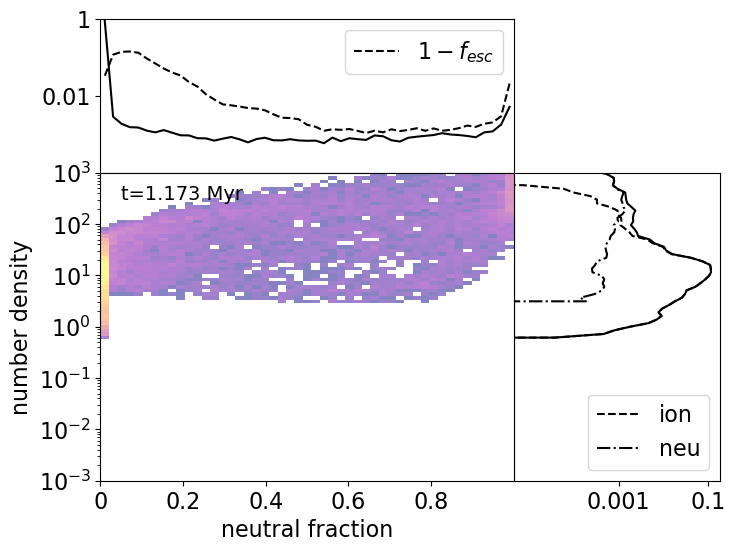

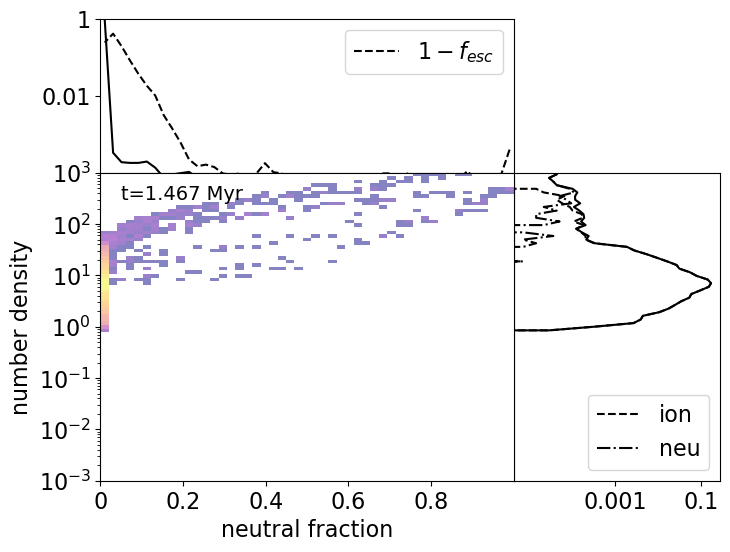

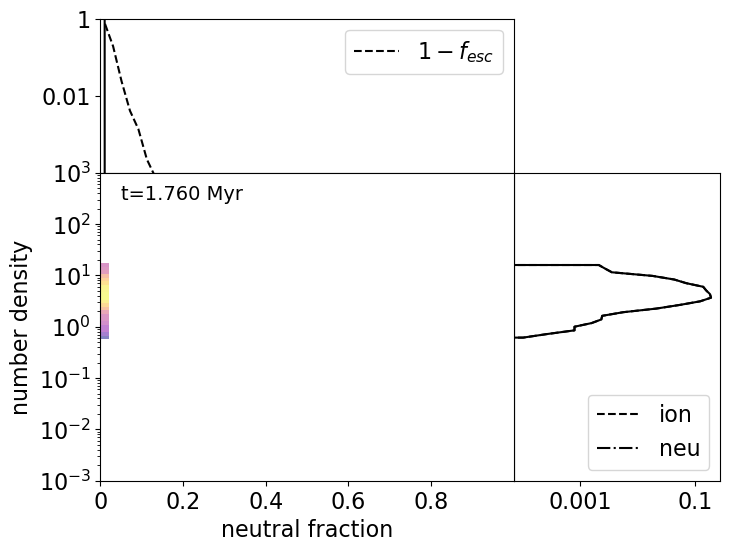

In [36]:
for num in [20,40,60,80,100,120]:
    nH_xn(s1,num)

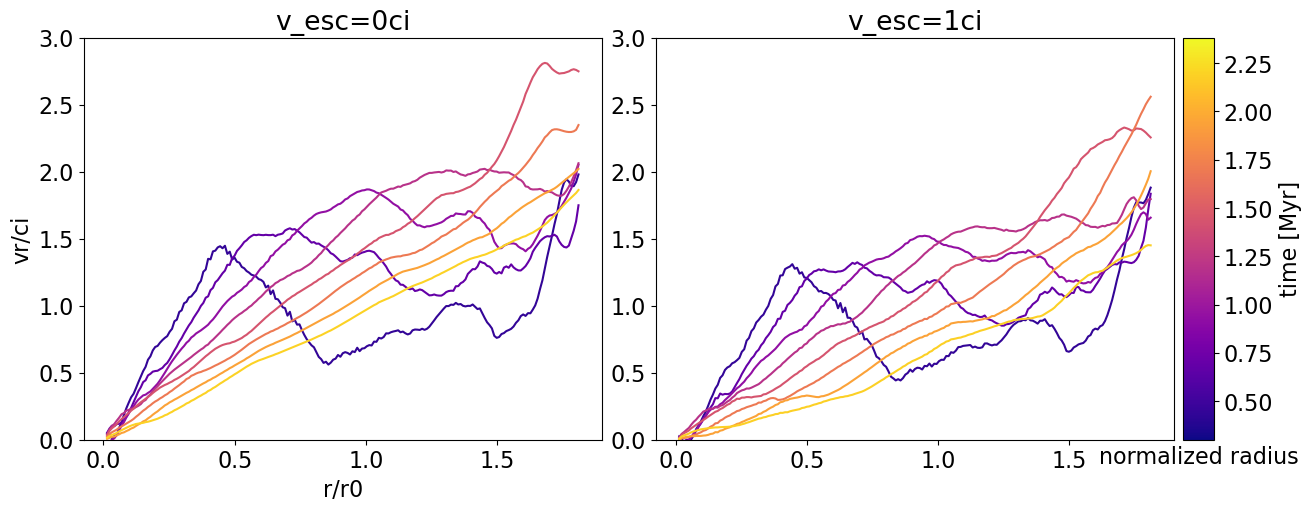

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=[0.5,0.5,0.03]))
norm = plt.Normalize(0.3, 0.8*s1.par['time']['tlim'])
cmap = mpl.cm.plasma

for i in range(30,151,17):
    ds=s1.load_hdf5(i,load_method='yt')
    add_fields(ds,s1)
    ad=ds.all_data()
    rr=dict_list[i]
    r0=rr['r0']

    hist_w_vr=np.histogram(ad['radius'], bins=bins['radius'], weights=ad['vr_ion'])
    x2,y2=hist_w_vr[1],hist_w_vr[0]

    hist_w_no=np.histogram(ad['radius'], bins=bins['radius'],weights=1-ad['neu_bool'])
    x3,y3=hist_w_no[1],hist_w_no[0]

    #n_rms=n_rms.to(yu.cm**(-3))
    a_para=rr['a_para']
    
    axes[0].plot(0.5*(x2[1:]+x2[:-1])/r0,y2/y3/ci,'-',c=cmap(norm(rr['time']*s1.u.Myr)))
axes[0].set_title('v_esc=0ci')
for i in range(30,151,17):
    ds=s2.load_hdf5(i,load_method='yt')
    add_fields(ds,s2)
    ad=ds.all_data()
    rr=dict_list2[i]
    r0=rr['r0']

    hist_w_vr=np.histogram(ad['radius'], bins=bins['radius'], weights=ad['vr_ion'])
    x2,y2=hist_w_vr[1],hist_w_vr[0]

    hist_w_no=np.histogram(ad['radius'], bins=bins['radius'],weights=1-ad['neu_bool'])
    x3,y3=hist_w_no[1],hist_w_no[0]

    #n_rms=n_rms.to(yu.cm**(-3))
    a_para=rr['a_para']
    
    axes[1].plot(0.5*(x2[1:]+x2[:-1])/r0,y2/y3/ci,'-',c=cmap(norm(rr['time']*s1.u.Myr)))
axes[1].set_title('v_esc=1ci')
plt.xlabel('normalized radius')
plt.ylabel('normalized m_evap')
axes[0].set_ylim(0,3)
axes[0].set_ylabel('vr/ci')
axes[0].set_xlabel('r/r0')
axes[1].set_ylim(0,3)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, cax=axes[-1], label='time [Myr]')

## normalized radial force

In [11]:
k=112
rr=dict_list2[k]
rr['a_para']
ds=s2.load_hdf5(k,load_method='yt')
add_fields(ds,s2)
dd=ds.all_data()
r0=rr['r0']
n_rms=np.sqrt(np.sum(((dd['nH_ion']**2*dd['cell_volume'])[dd['radius']<r0]))
                        /np.sum(dd['cell_volume'][(dd['radius']<r0)&(dd['r0']<0.5)])).to(yu.cm**(-3))
nf=n_rms.value*4*np.pi*1.4*ci**2*r0**2


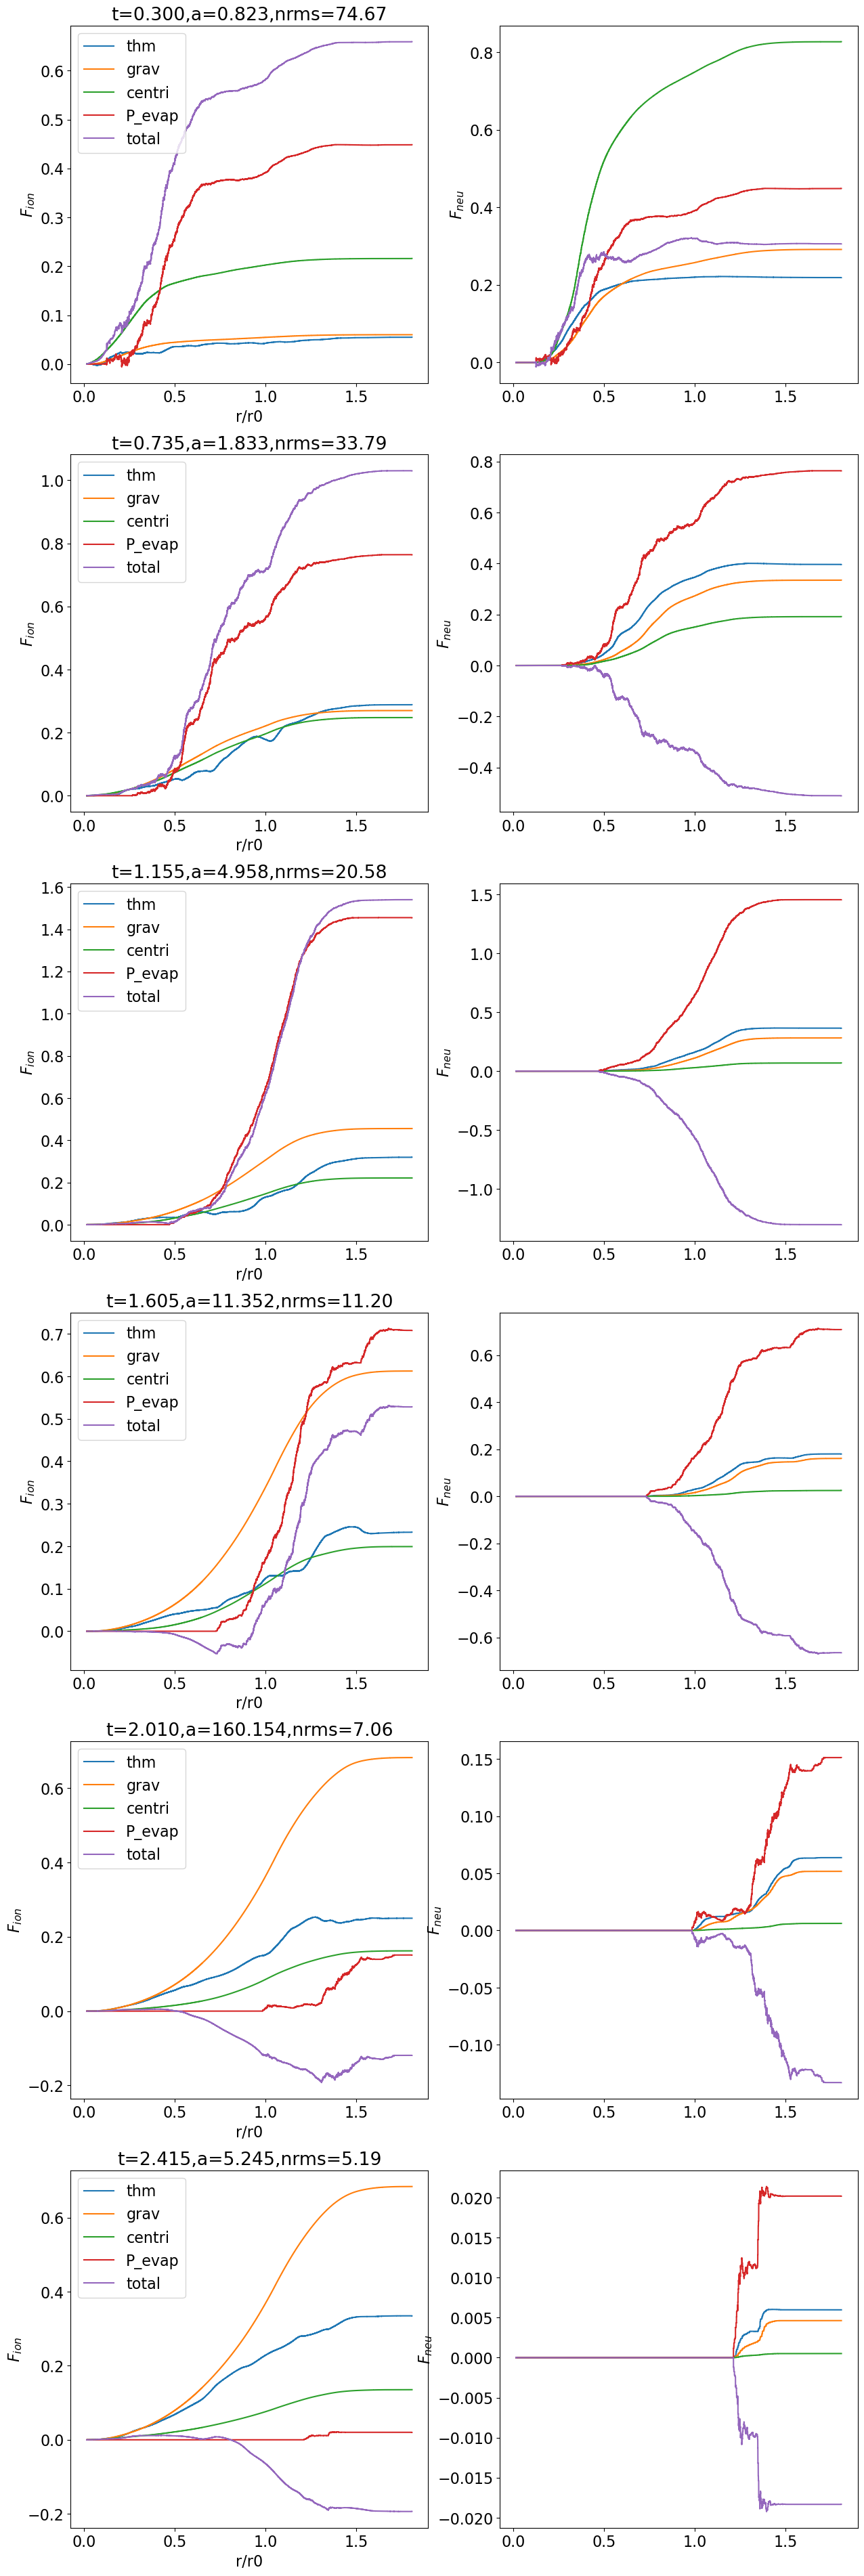

In [12]:

fig,axes=plt.subplots(6,2,figsize=(15,48))
t_list=[20,49,77,107,134,161]
for i in range(len(t_list)):
    k=t_list[i]
    rr=dict_list2[k]
    rr['a_para']
    ds=s2.load_hdf5(k,load_method='yt')
    add_fields(ds,s2)
    dd=ds.all_data()
    r0=rr['r0']
    n_rms=np.sqrt(np.sum(((dd['nH_ion']**2*dd['cell_volume'])[dd['radius']<r0]))
                        /np.sum(dd['cell_volume'][(dd['radius']<r0)&(dd['r0']<0.5)])).to(yu.cm**(-3))
    nf=n_rms.value*4*np.pi*1.4*ci**2*r0**2
    factor=(s2.u.time/s2.u.mass).value
    axes[i][0].plot(rr['r']/rr['r0'],-rr['F_thm_ion_r']/nf,label='thm')
    axes[i][0].plot(rr['r']/rr['r0'],-rr['F_grav_ion_r']/nf,label='grav')
    axes[i][0].plot(rr['r']/rr['r0'],rr['centri_ion_r']/nf,label='centri')
    axes[i][0].plot(rr['r']/rr['r0'],rr['dot_P_ev']*factor/nf,label='P_evap')
    axes[i][0].plot(rr['r']/rr['r0'],(-np.array([rr['F_thm_ion_r']])[0]+np.array([rr['F_grav_ion_r']])[0]+np.array([rr['centri_ion_r']])[0]+np.array([rr['dot_P_ev']])[0]*factor)/nf,label='total')
    axes[i][0].legend(loc='upper left')
    axes[i][0].set_title('t={:.3f}'.format(rr['time'])+',a={:.3f}'.format(rr['a_para'])+',nrms={:.2f}'.format(n_rms.value))
    axes[i][0].set_ylabel('$F_{ion}$')
    axes[i][0].set_xlabel('r/r0')
    axes[i][1].plot(rr['r']/rr['r0'],-rr['F_thm_neu_r']/nf,label='thm_neu')
    axes[i][1].plot(rr['r']/rr['r0'],-rr['F_grav_neu_r']/nf,label='grav_neu')
    axes[i][1].plot(rr['r']/rr['r0'],rr['centri_neu_r']/nf,label='centri_neu')
    axes[i][1].plot(rr['r']/rr['r0'],rr['dot_P_ev']*factor/nf,label='P_evap')
    axes[i][1].plot(rr['r']/rr['r0'],(-np.array([rr['F_thm_neu_r']])[0]+np.array([rr['F_grav_neu_r']])[0]+np.array([rr['centri_neu_r']])[0]-np.array([rr['dot_P_ev']])[0]*factor)/nf,label='total')
    axes[i][1].set_ylabel('$F_{neu}$')

## scaling relation

In [8]:
ph=str(pathlist2[0])+'/evap_dictionary/for_scaling'
with open(ph, 'rb') as fr:
    scale_dict = pickle.load(fr)

In [9]:
history_dict={}
for key in scale_dict[0].keys():
    if np.shape(np.array([scale_dict[0][key]]))==(1,):
        history_dict[key]=np.array([rr[key] for rr in scale_dict])
history_dict.keys()

dict_keys(['time', 'fV_ion', 'n_ion_rms', 'f_thick', 'f_thin_esc', 'f_esc', 'f_wind', 'n_mean', 'rho_w_Om', 'vr_w_mass', 'f_partial', 'vr_w_rhoOm'])

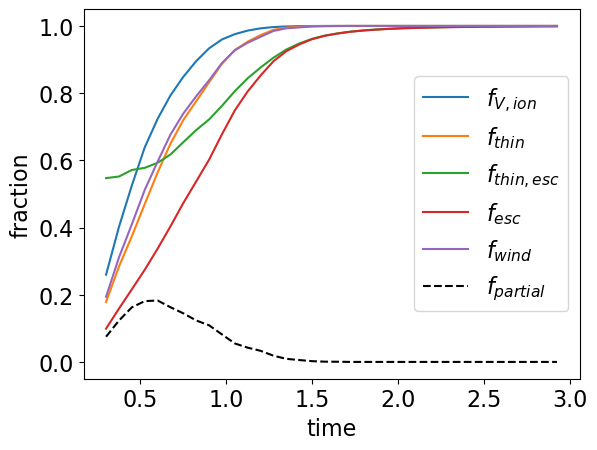

In [15]:
plt.plot(history_dict['time'],history_dict['fV_ion'],label='$f_{V,ion}$')
plt.plot(history_dict['time'],1-history_dict['f_thick'],label='$f_{thin}$')
plt.plot(history_dict['time'],history_dict['f_thin_esc'],label='$f_{thin,esc}$')
plt.plot(history_dict['time'],history_dict['f_esc'],label='$f_{esc}$')
plt.plot(history_dict['time'],history_dict['f_wind'],label='$f_{wind}$')
plt.plot(history_dict['time'],history_dict['f_partial'],'k--',label='$f_{partial}$')
plt.xlabel('time')
plt.ylabel('fraction')
plt.legend()

### 1) n_rms

In [10]:
r0=dict_list[0]['r0']

In [11]:
Ti4=0.8
Qi=s1.par['problem']['Qi']*(1-history_dict['f_esc'])
n_scale=17.9*(Qi/1e+49)**(0.5)*Ti4**(0.41)*(r0/10)**(-1.5)*history_dict['fV_ion']**(-0.5)

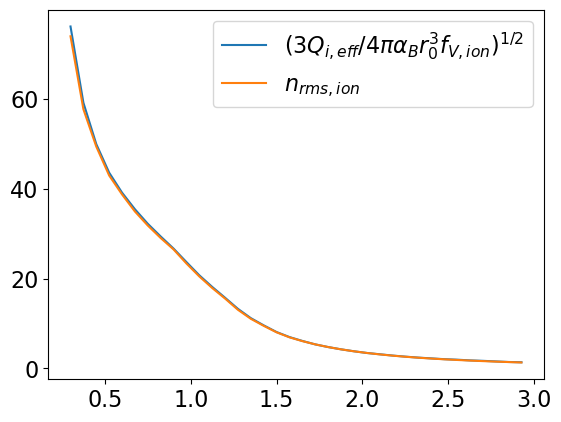

In [22]:
plt.plot(history_dict['time'],n_scale,label=r'$(3Q_{i,eff}/4\pi\alpha_{B}r_0^3 f_{V,ion})^{1/2}$')
plt.plot(history_dict['time'],history_dict['n_ion_rms'],label='$n_{rms,ion}$')
plt.legend()

### problem: not only dependency on 'a' parameter, but also high F value

In [12]:
Ti4=0.8
Qi=s1.par['problem']['Qi']*(1-history_dict['f_esc'])
M_dot_scale=4.99*1000*(Qi/1e+49)**(2/3)*(history_dict['n_ion_rms']/100)**(-1/3)*Ti4**1.04*history_dict['f_wind']
M_out=np.array([rr['M_out_ion'] for rr in dict_list[20::5]])*(s1.u.mass/s1.u.time).value
M_evap=np.array([(np.array(rr['dot_M_ev'])[np.array(rr['r'])<=rr['r0']])[-1] for rr in dict_list[20::5]])
#FM_dot=M_out/(4*np.pi*r0**2*ci*1.4*history_dict['n_ion_rms'])/history_dict['f_wind']

a_para=np.array([rr['a_para'] for rr in dict_list[20::5]])
a_para2=np.array([rr['a_para2'] for rr in dict_list[20::5]])
a_err=np.sqrt(np.array([rr['a_err'] for rr in dict_list[20::5]]))
a_err2=np.sqrt(np.array([rr['a_err2'] for rr in dict_list[20::5]]))
Mdot_=4*np.pi*r0**2*history_dict['rho_w_Om']*history_dict['vr_w_mass']*(s1.u.mass/s1.u.time).value*history_dict['f_wind']


In [13]:
M_sphere=np.array([np.max(rr['Mion_r'][rr['r']<rr['r0']]).value for rr in dict_list[20::5]])
dMdt=(M_sphere[1:]-M_sphere[:-1])/(history_dict['time'][1:]-history_dict['time'][:-1])/s1.u.time.value

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_93030/4202225757.py:5: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(history_dict['time'][:-1],dMdt,label='$\dot{M}_{ion,sphere}$')
/tmp/ipykernel_93030/4202225757.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(history_dict['time'],M_out,label='$\dot{M}_{i,out}$')
/tmp/ipykernel_93030/4202225757.py:7: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(history_dict['time'][:-1],dMdt+M_out[:-1],label='$\dot{M}_{ion,sphere}$')


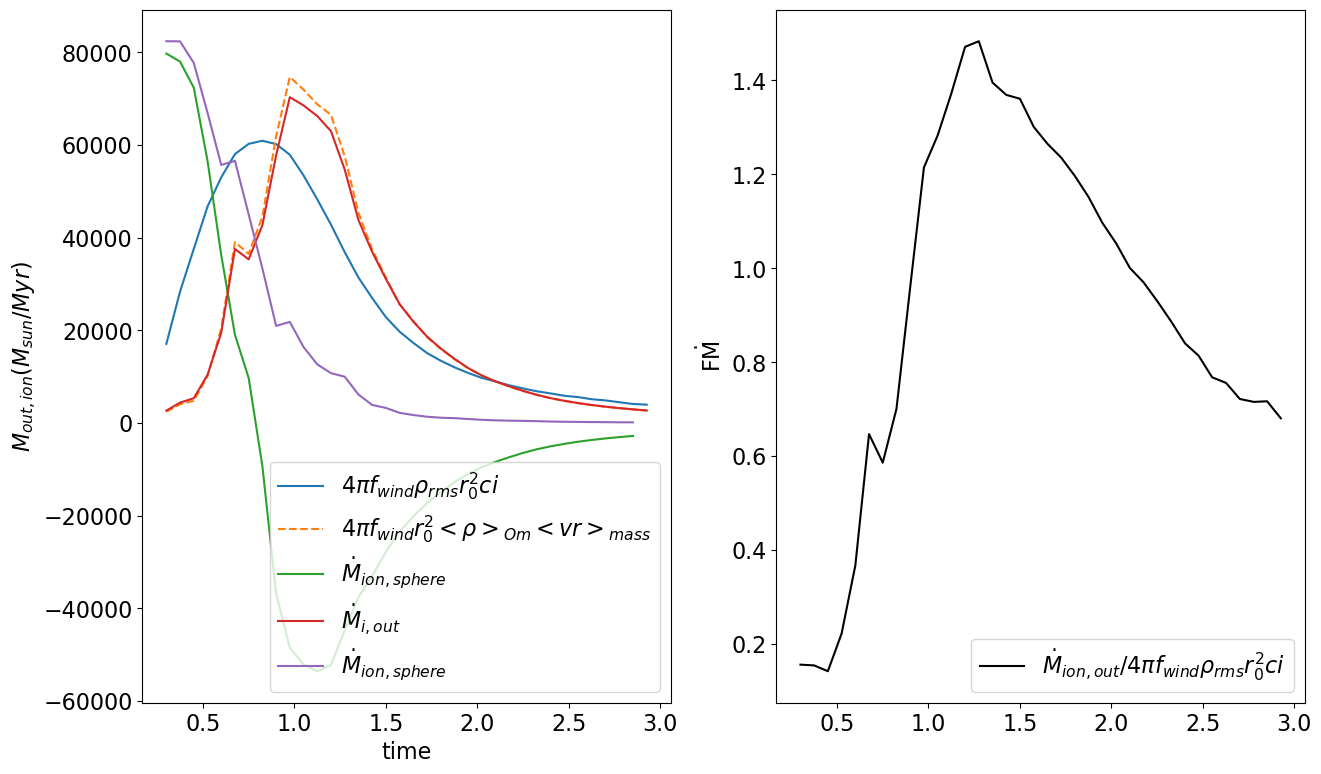

In [15]:
fig,axes=plt.subplots(1,2,figsize=(15,9))
axes[0].plot(history_dict['time'],M_dot_scale,label=r'$4\pi f_{wind}\rho_{rms} r_0^2ci$')
#axes[0].plot(history_dict['time'],M_evap,label=r'$\dot{M}_{evap}$')
axes[0].plot(history_dict['time'],Mdot_,'--',label=r'$4\pi f_{wind} r_0^2 <\rho>_{Om} <vr>_{mass}$')
axes[0].plot(history_dict['time'][:-1],dMdt,label='$\dot{M}_{ion,sphere}$')
axes[0].plot(history_dict['time'],M_out,label='$\dot{M}_{i,out}$')
axes[0].plot(history_dict['time'][:-1],dMdt+M_out[:-1],label='$\dot{M}_{ion,sphere}$')
#axes[0].plot(t_arr,M_dot_scale*scale_FM_dot,label='$\dot{M}_{scale}\\times F\dot{M}$')
#axes[0].plot(history_dict['time'],M_dot_scale*FM_dot,label=r'$F\dot{M}\times 4\pi f_{wind}\rho_{rms} r_0^2ci$')
#plt.plot(t_arr+0.2,M_dot_scale,label='M_dot_scale with time delay')
axes[0].legend()
axes[0].set_xlabel('time')
axes[0].set_ylabel('$M_{out,ion}(M_{sun}/Myr$)')
#plt.yscale('log')
axes[1].plot(history_dict['time'],M_out/M_dot_scale,'k',label=r'$\dot{M}_{ion,out}/4\pi f_{wind}\rho_{rms} r_0^2ci$')
#axes[1].plot(history_dict['time'],M_evap/M_dot_scale,'k--',label=r'$\dot{M}_{evap}/4\pi f_{wind}\rho_{rms} r_0^2ci$')
axes[1].set_ylabel(r'$\rm F\dot{M}$')
#axes[1].set_ylim(0,2)
axes[1].legend(loc='lower right')

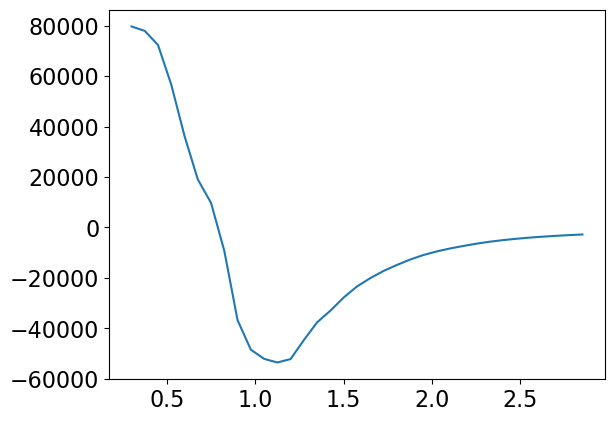

In [55]:
plt.plot(history_dict['time'][:-1],dMdt)

(0.0, 2.0)

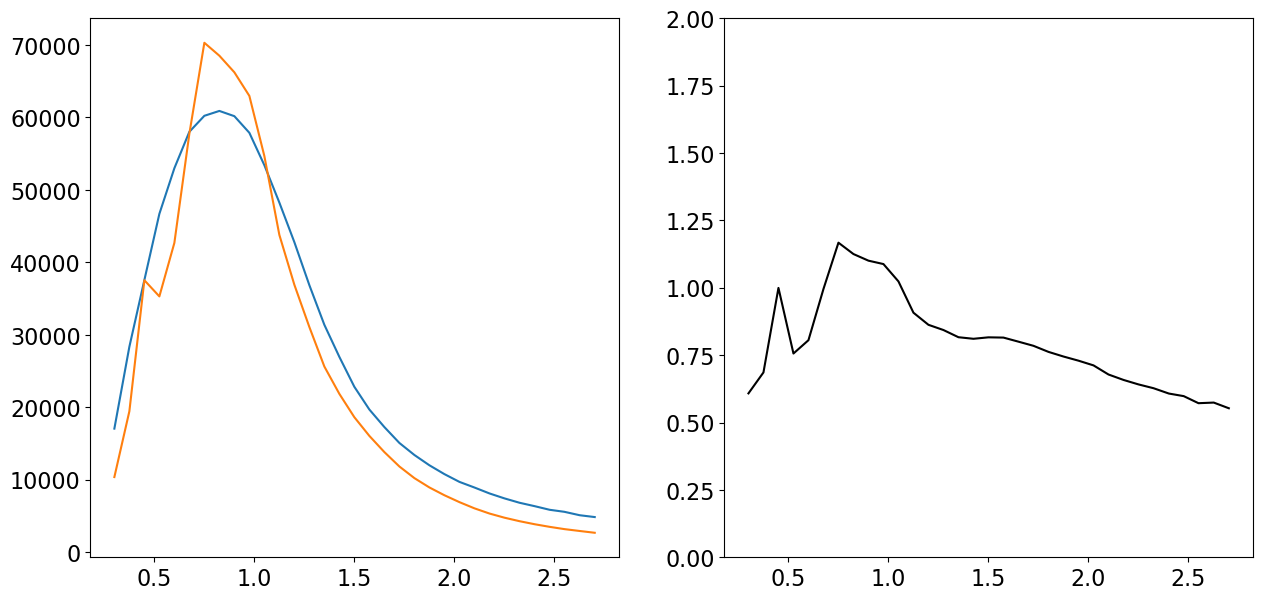

In [68]:
delay=3
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(history_dict['time'][:-delay],M_dot_scale[:-delay])
axes[0].plot(history_dict['time'][:-delay],M_out[delay:])
axes[1].plot(history_dict['time'][:-delay],M_out[delay:]/M_dot_scale[:-delay],'k',label=r'$\dot{M}_{ion,out}/4\pi f_{wind}\rho_{rms} r_0^2ci$')
axes[1].set_ylim(0,2)

In [ ]:
h=pa.read_hst(

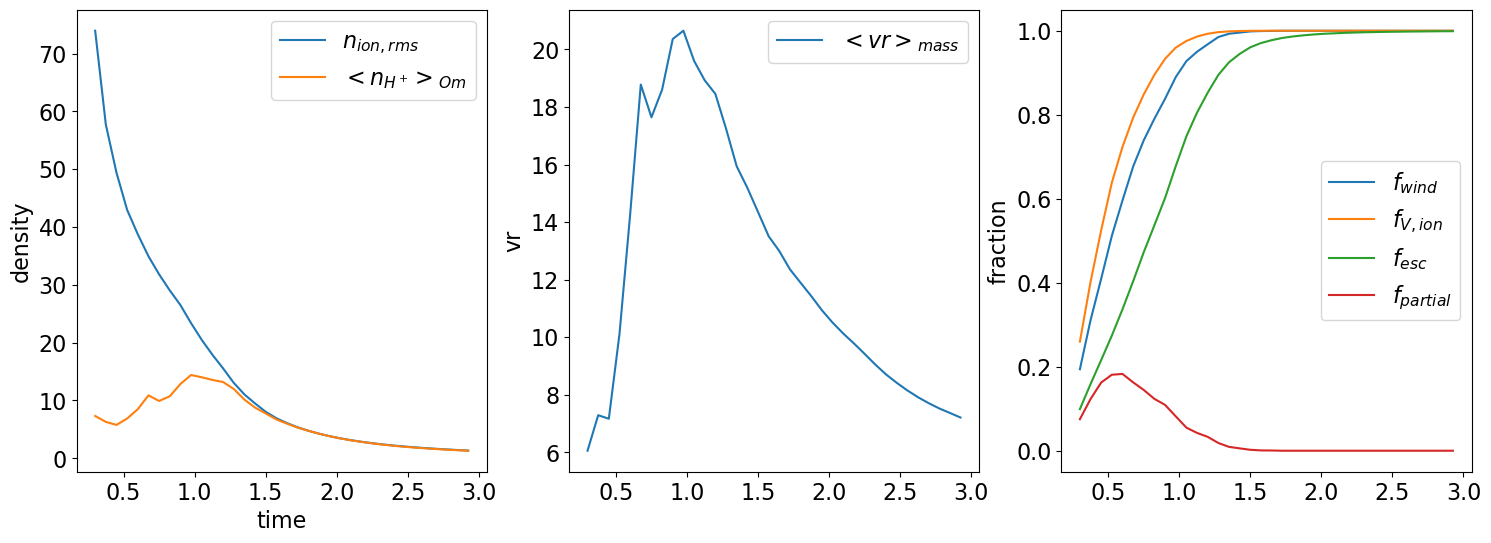

In [43]:
fig,axes=plt.subplots(1,3,figsize=(18,6))
axes[0].plot(history_dict['time'],history_dict['n_ion_rms'],label='$n_{ion,rms}$')
axes[0].plot(history_dict['time'],history_dict['rho_w_Om']/1.4,label=r'$<n_{H^+}>_{Om}$')
axes[0].legend()
axes[0].set_xlabel('time')
axes[0].set_ylabel('density')
axes[1].plot(history_dict['time'],history_dict['vr_w_mass'],label='$<vr>_{mass}$')
axes[1].set_ylabel('vr')
axes[1].legend()

axes[2].plot(history_dict['time'],history_dict['f_wind'],label='$f_{wind}$')
axes[2].plot(history_dict['time'],history_dict['fV_ion'],label='$f_{V,ion}$')
axes[2].plot(history_dict['time'],history_dict['f_esc'],label='$f_{esc}$')
axes[2].plot(history_dict['time'],history_dict['f_partial'],label='$f_{partial}$')
axes[2].set_ylabel('fraction')
axes[2].legend()


## why is FM_dot higher in simulation result than theoretical model?

<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\%'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_142452/2702227096.py:4: SyntaxWarning: invalid escape sequence '\%'
  axes[0].plot(a_para2[a_err2<err_cut],FM_dot[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
/tmp/ipykernel_142452/2702227096.py:7: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$F\dot{M}_{out}$')
/tmp/ipykernel_142452/2702227096.py:15: SyntaxWarning: invalid escape sequence '\d'
  axes[1].set_ylabel('$F\dot{M}_{evap}$')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


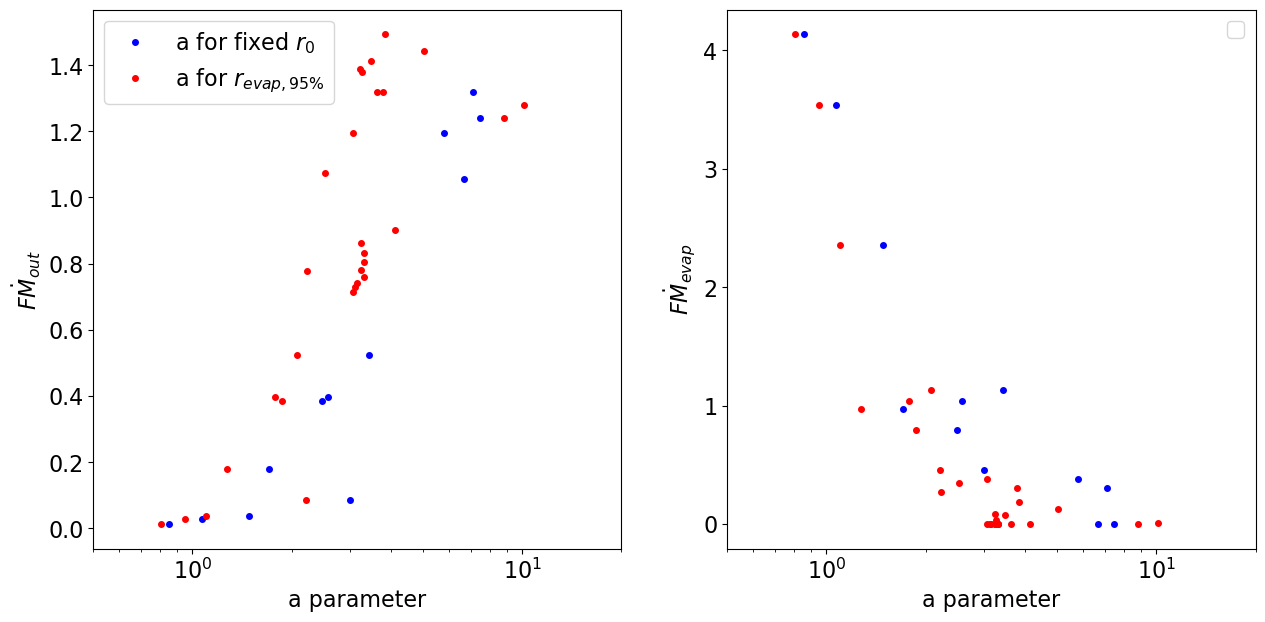

In [33]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
err_cut=1e-3
axes[0].plot(a_para[a_err<err_cut],FM_dot[a_err<err_cut],'bo',ms=4,label='a for fixed $r_0$')
axes[0].plot(a_para2[a_err2<err_cut],FM_dot[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
axes[0].set_xscale('log')
axes[0].set_xlabel('a parameter')
axes[0].set_ylabel('$F\dot{M}_{out}$')
axes[0].set_xlim(5e-1,2e+1)
axes[0].legend()

axes[1].plot(a_para[a_err<err_cut],M_evap[a_err<err_cut]/M_dot_scale[a_err<err_cut],'bo',ms=4)
axes[1].plot(a_para2[a_err2<err_cut],M_evap[a_err2<err_cut]/M_dot_scale[a_err2<err_cut],'ro',ms=4)
axes[1].set_xscale('log')
axes[1].set_xlabel('a parameter')
axes[1].set_ylabel('$F\dot{M}_{evap}$')
axes[1].set_xlim(5e-1,2e+1)
axes[1].legend()

In [21]:
Ti4=0.8
Qi=s1.par['problem']['Qi']*(1-history_dict['f_esc'])
P_dot_scale=5.55*10000*(Qi/1e+49)**(2/3)*(history_dict['n_ion_rms']/100)**(-1/3)*Ti4**1.54*history_dict['f_wind']
P_out=np.array([rr['P_out_ion'] for rr in dict_list[20::5]])
FP_dot=P_out/(4*np.pi*history_dict['f_wind']*r0**2*ci**2*1.4*history_dict['n_ion_rms'])
P_evap=np.array([(np.array(rr['dot_P_ev'])[np.array(rr['r'])<=rr['r0']])[-1] for rr in dict_list[20::5]])

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_142452/2953580435.py:3: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(history_dict['time'],P_out*(s1.u.mass/s1.u.time).value,label='$\dot{P}_{ion,out}$')
/tmp/ipykernel_142452/2953580435.py:4: SyntaxWarning: invalid escape sequence '\d'
  axes[0].plot(history_dict['time'],P_evap,label='$\dot{P}_{evap}$')
/tmp/ipykernel_142452/2953580435.py:9: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$\dot{P}_{i}(M_{sun}km/s/Myr$)')
/tmp/ipykernel_142452/2953580435.py:11: SyntaxWarning: invalid escape sequence '\d'
  axes[1].plot(history_dict['time'],P_evap

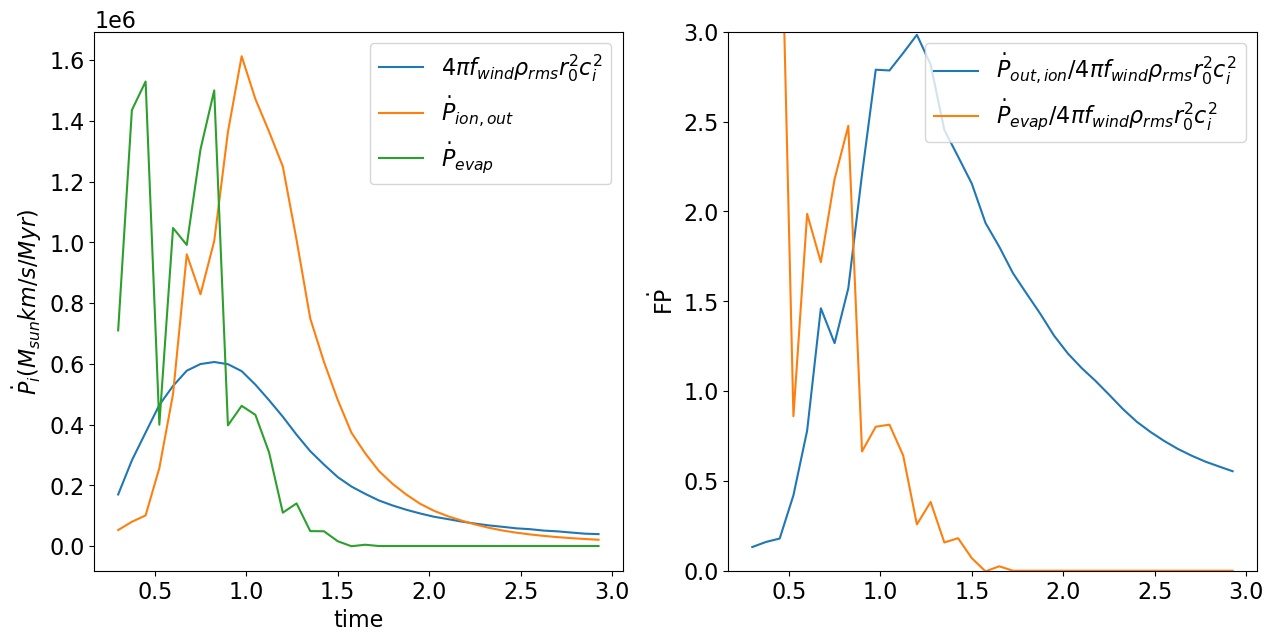

In [25]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(history_dict['time'],P_dot_scale,label=r'$4\pi f_{wind} \rho_{rms} r_0^2 c_i^2$')
axes[0].plot(history_dict['time'],P_out*(s1.u.mass/s1.u.time).value,label='$\dot{P}_{ion,out}$')
axes[0].plot(history_dict['time'],P_evap,label='$\dot{P}_{evap}$')
#axes[0].plot(history_dict['time'],P_dot_scale*FP_dot,label='$4\pi f_{wind} \\rho_{rms} r_0^2 c_i^2\\times F\dot{P} $')
#plt.plot(t_arr+0.2,P_dot_scale,label='P_dot_scale with time delay')
axes[0].legend()
axes[0].set_xlabel('time')
axes[0].set_ylabel('$\dot{P}_{i}(M_{sun}km/s/Myr$)')
axes[1].plot(history_dict['time'],FP_dot,label=r'$\dot{P}_{out,ion}/4\pi f_{wind} \rho_{rms} r_0^2 c_i^2$')
axes[1].plot(history_dict['time'],P_evap/P_dot_scale,label='$\dot{P}_{evap}/4\pi f_{wind} \\rho_{rms} r_0^2 c_i^2$')
#axes[1].plot(history_dict['time'],P_out_arr*(s1.u.mass/s1.u.time).value/P_dot_scale,label='$\dot{P}_{ion,out}/{\dot{P}_{scale}}$')
axes[1].set_ylabel(r'$\rm F\dot{P}$')
axes[1].set_ylim(0,3)
axes[1].legend()

<>:3: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_142452/1191844817.py:3: SyntaxWarning: invalid escape sequence '\%'
  axes[0].plot(a_para2[a_err2<err_cut],FP_dot[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
/tmp/ipykernel_142452/1191844817.py:6: SyntaxWarning: invalid escape sequence '\d'
  axes[0].set_ylabel('$F\dot{P}_{out}$')
/tmp/ipykernel_142452/1191844817.py:11: SyntaxWarning: invalid escape sequence '\%'
  axes[1].plot(a_para2[a_err2<err_cut],P_evap[a_err2<err_cut]/P_dot_scale[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
/tmp/ipykernel_142452/1191844817.py:14: SyntaxWarning: invalid escape s

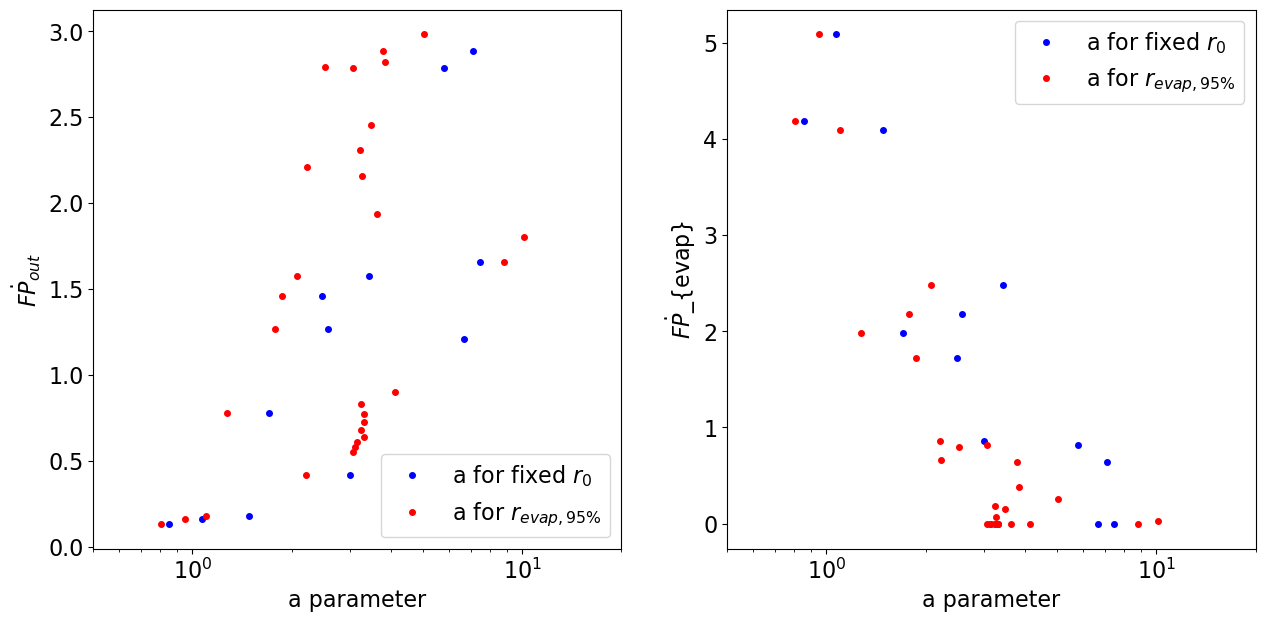

In [26]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(a_para[a_err<err_cut],FP_dot[a_err<err_cut],'bo',ms=4,label='a for fixed $r_0$')
axes[0].plot(a_para2[a_err2<err_cut],FP_dot[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
axes[0].set_xscale('log')
axes[0].set_xlabel('a parameter')
axes[0].set_ylabel('$F\dot{P}_{out}$')
axes[0].set_xlim(5e-1,2e+1)
axes[0].legend()

axes[1].plot(a_para[a_err<err_cut],P_evap[a_err<err_cut]/P_dot_scale[a_err<err_cut],'bo',ms=4,label='a for fixed $r_0$')
axes[1].plot(a_para2[a_err2<err_cut],P_evap[a_err2<err_cut]/P_dot_scale[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
axes[1].set_xscale('log')
axes[1].set_xlabel('a parameter')
axes[1].set_ylabel('$F\dot{P}$_{evap}$')
axes[1].set_xlim(5e-1,2e+1)
axes[1].legend()

In [22]:
Ti4=0.8
Qi=s1.par['problem']['Qi']*(1-history_dict['f_esc'])
FM_arr=history_dict['n_mean']/history_dict['n_ion_rms']
M_scale=4.64*100*(Qi/1e+49)**(1)*(history_dict['n_ion_rms']/100)**(-1)*Ti4**0.82#*history_dict['fV_ion']
Mion=np.array([(rr['Mion_r'][rr['r']<r0])[-1].value for rr in dict_list[20::5]])

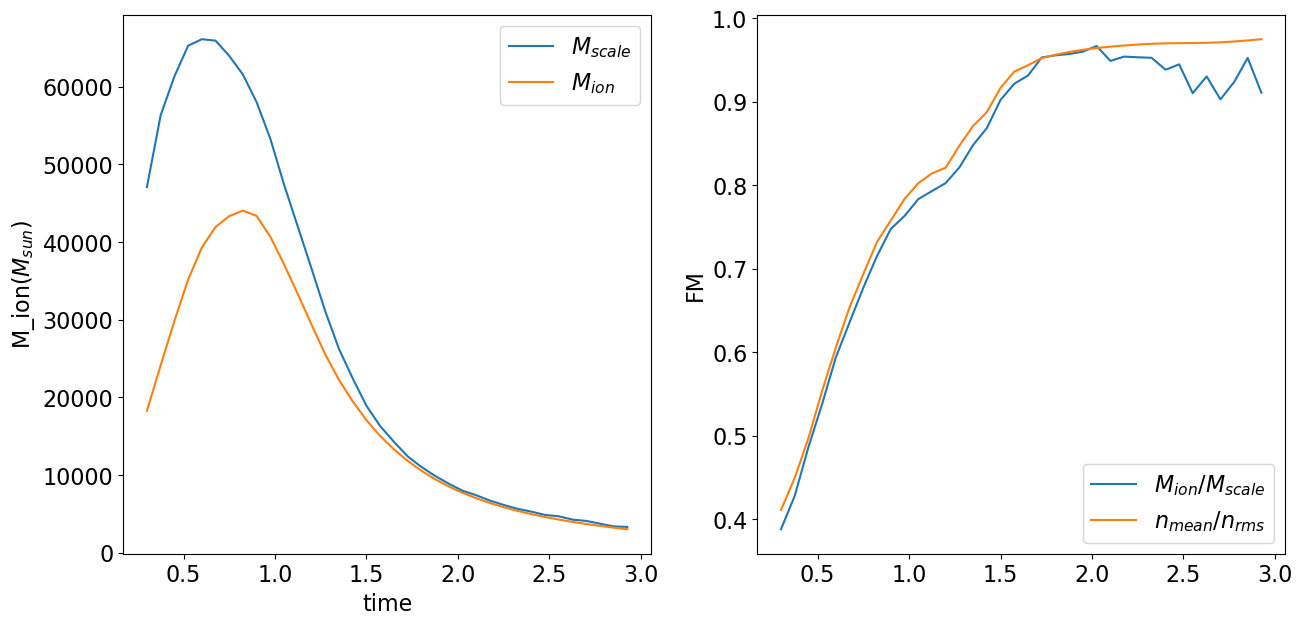

In [31]:
fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].plot(history_dict['time'],M_scale,label='$M_{scale}$')
axes[0].plot(history_dict['time'],Mion,label='$M_{ion}$')
#axes[0].plot(history_dict['time'],M_scale*FM_arr,label='$M_{scale}\\times FM$')
#axes[0].plot(history_dict['time'],np.array(FM_arr/scale_FM_dot*FM_dot_arr)*M_scale,label=r'using $\dot{M}_{ion,out}/\dot{M}_{scale}$')
#plt.plot(t_arr+0.2,M_dot_scale,label='M_dot_scale with time delay')
axes[0].legend()
axes[0].set_xlabel('time')
axes[0].set_ylabel('M_ion($M_{sun}$)')
#axes[0].yscale('log')

axes[1].plot(history_dict['time'],Mion/M_scale,label='$M_{ion}/M_{scale}$')
axes[1].plot(history_dict['time'],FM_arr,label='$n_{mean}/n_{rms}$')
#axes[1].plot(history_dict['time'],scale_FM,label=r'$3F\dot{M}\int^1_{\bar{r}_{min}}\dot{\bar{M}}/\bar{v}d\bar{r}$')
#axes[1].plot(history_dict['time'],scale_FM/scale_FM_dot*FM_dot_arr,label=r'using $\dot{M}_{ion,out}/\dot{M}_{scale}$')
axes[1].set_ylabel('FM')
axes[1].legend(loc='lower right')

<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_134505/800673640.py:2: SyntaxWarning: invalid escape sequence '\%'
  plt.plot(a_para2[a_err2<err_cut],Mion[a_err2<err_cut]/M_scale[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')


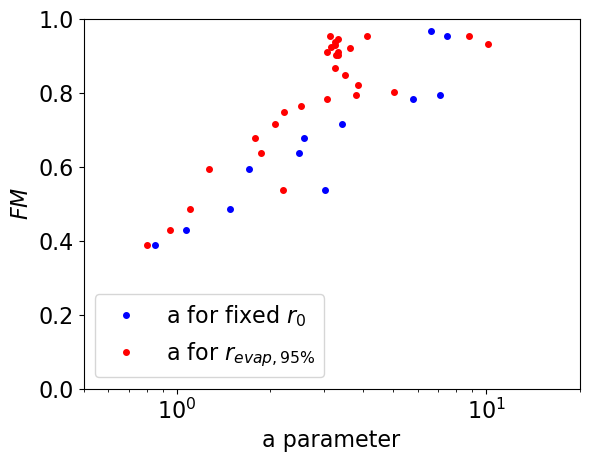

In [33]:
plt.plot(a_para[a_err<err_cut],Mion[a_err<err_cut]/M_scale[a_err<err_cut],'bo',ms=4,label='a for fixed $r_0$')
plt.plot(a_para2[a_err2<err_cut],Mion[a_err2<err_cut]/M_scale[a_err2<err_cut],'ro',ms=4,label='a for $r_{evap,95\%}$')
plt.xscale('log')
plt.xlabel('a parameter')
plt.ylabel('$FM$')
plt.xlim(5e-1,2e+1)
plt.ylim(0,1)
plt.legend()

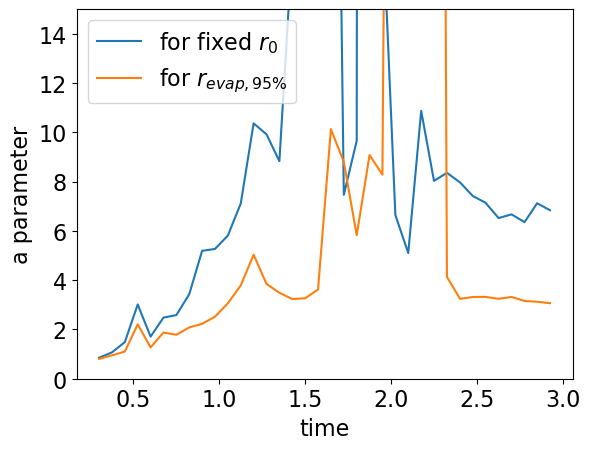

In [48]:
plt.plot(history_dict['time'],a_para,label='for fixed $r_0$')
plt.plot(history_dict['time'],a_para2,label=r'for $r_{evap,95\%}$')

plt.ylim(0,15)
plt.xlabel('time')
plt.ylabel('a parameter')
plt.legend()

## 2D radial profile of Sigma & Em

In [28]:
def projectionplot(field,ax_num):
    return np.sum(field,axis=ax_num)

In [33]:
def Sig_Em_2D(num,s):
    ds=s.load_hdf5(num,load_method='yt')
    add_fields(ds,s)
    ad=ds.all_data()
    ad_grid = ds.covering_grid(level=0, left_edge=ds.domain_left_edge, dims=ds.domain_dimensions)
    dz=ad_grid['dz']
    R=np.sqrt(ad_grid['x'][:,:,0]**2+ad_grid['y'][:,:,0]**2)
    Sig=projectionplot(ad_grid['rho']*dz*s.u.mass.value,2)
    Em=projectionplot(ad_grid['ne^2']*dz/s.par['units']['length_cgs']**6,2)
    dA=ad_grid['dx'][:,:,0]*ad_grid['dy'][:,:,0]
    
    m,n=np.shape(R)
    R1d=np.reshape(R,[1,m*n])[0]
    Sig1d=np.reshape(Sig,[1,m*n])[0]
    Em1d=np.reshape(Em,[1,m*n])[0]
    dA1d=np.reshape(dA,[1,m*n])[0]
    x,y=np.histogram(R1d,bins=np.linspace(0,np.max(R1d),50),weights=Sig1d*dA1d)
    x=np.array([np.sum(x[:k]) for k in range(len(x))])
    x2,y2=np.histogram(R1d,bins=np.linspace(0,np.max(R1d),50),weights=Em1d*dA1d)
    x2=np.array([np.sum(x2[:k]) for k in range(len(x2))])
    fig = plt.figure(figsize=(9,6)) 
    ax1 = fig.add_subplot()

    ax1.tick_params(axis='x', size=5, labelsize=15) 
    ax1.plot(0.5*(y[:-1]+y[1:]),x,'b',label='$\int_{0}^{R}\Sigma(r) 2\pi rdr$ in 2d')
    ax1.set_ylabel('Mass', size=20)
    ax1.tick_params(axis='y', size=5, labelsize=15)
    plt.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(0.5*(y2[:-1]+y2[1:]),x2,'r',label='$\int_{0}^{R}Em(r) 2\pi rdr$ in 2d')
    ax2.set_ylabel('cumulative Emission', size=20)
    ax2.tick_params(axis='y', size=5, labelsize=15)
    plt.legend(loc='lower right')
    plt.title('t={:.2f}'.format(ds.current_time.to('Myr')))

<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:30: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_20823/1257240401.py:25: SyntaxWarning: invalid escape sequence '\i'
  ax1.plot(0.5*(y[:-1]+y[1:]),x,'b',label='$\int_{0}^{R}\Sigma(r) 2\pi rdr$ in 2d')
/tmp/ipykernel_20823/1257240401.py:30: SyntaxWarning: invalid escape sequence '\i'
  ax2.plot(0.5*(y2[:-1]+y2[1:]),x2,'r',label='$\int_{0}^{R}Em(r) 2\pi rdr$ in 2d')


In [25]:
pathlist2

[PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_0.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_0.5'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_1.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_1.5'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_2.0'),
 PosixPath('/data/cjlee/hii/various_nH0_Qi/vesc_test3/hii_Q51.0n3.0_nx_128_fdt_0.1_navg_15_vesc_2.5')]

In [31]:
s3=pa.LoadSim(str(pathlist2[5]))

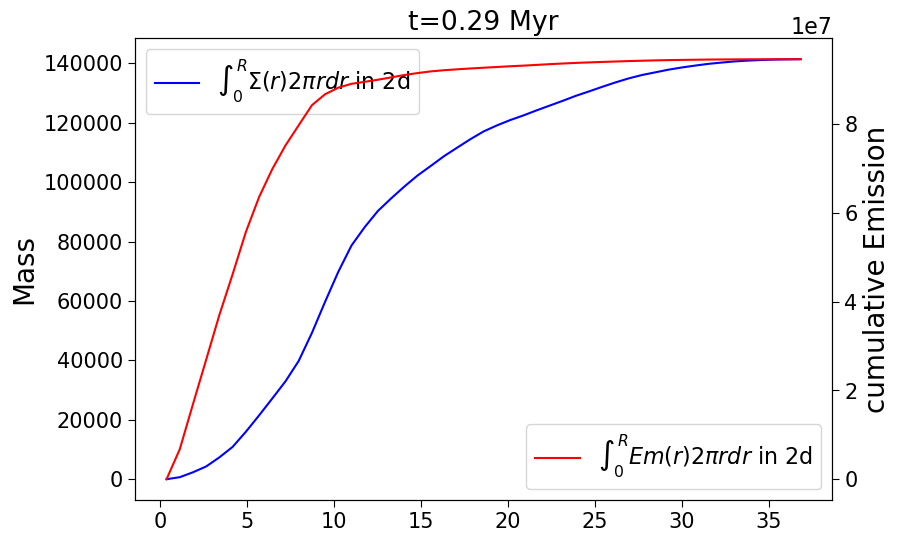

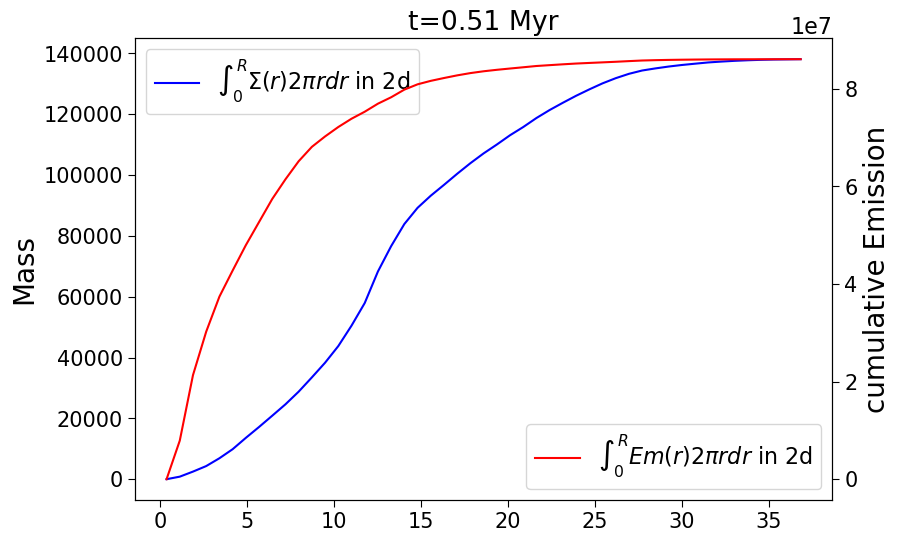

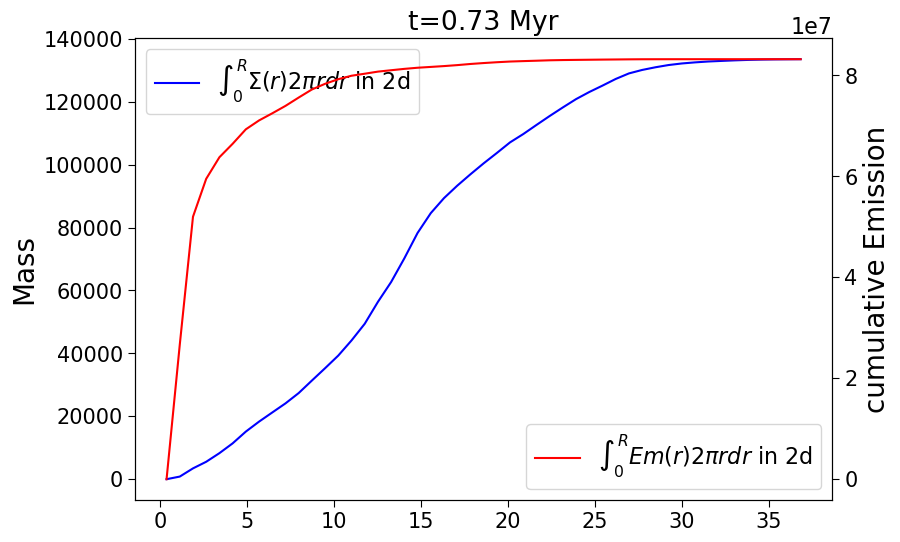

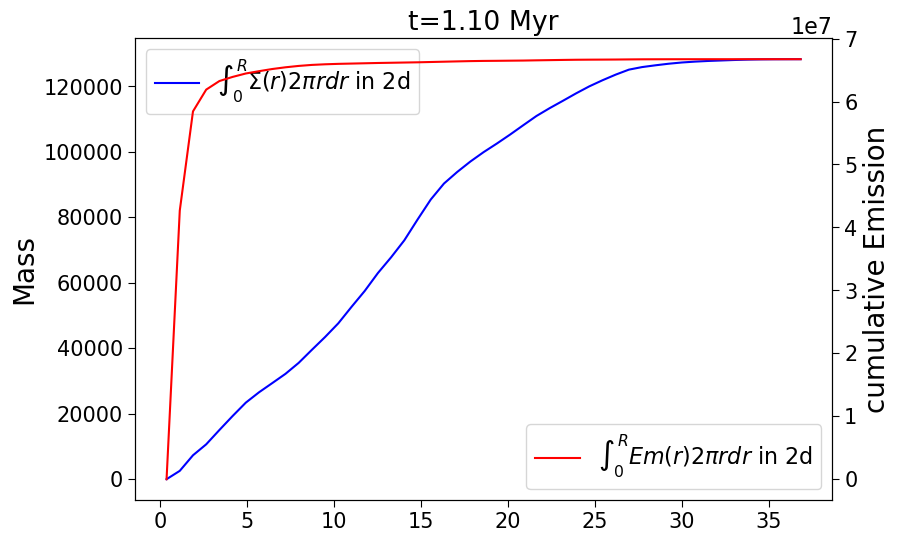

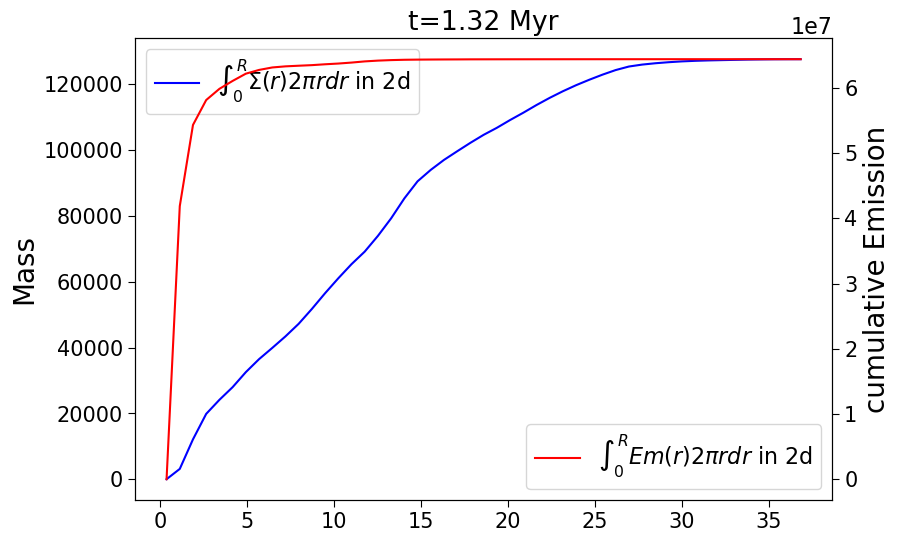

In [34]:
for i in [20,35,50,75,90]:
    Sig_Em_2D(i,s3)